In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline
tf.config.set_visible_devices([], 'GPU')

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [4]:
print(len(train_df.landmark_id.unique()))
print(train_df.landmark_id.max())
print(train_df.landmark_id.min())


81313
203092
1


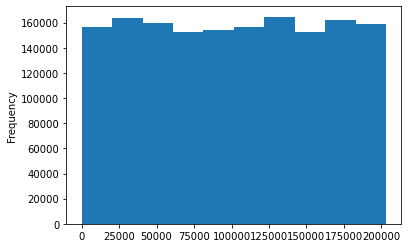

In [5]:
train_df.landmark_id.plot(kind='hist')

In [6]:
train_df.loc[train_df.id == '0000ae056149919f']

,id,landmark_id
995306,0000ae056149919f,128432


In [7]:
for filename in os.listdir('train/0/0/0'):
    print(os.path.splitext(filename)[0])

0000059611c7d079
000014b1f770f640
000015f76534add3
00001ae42cd00356
00001b2ba2c69ac5
000020dfc079c013
000022ce0b9d8966
0000341f232b1354
00003fe2469cdbf5
00004208e2bc0cc0
000054af45275b62
00005f617bc1763e
00007594d1b97325
0000ae056149919f
0000c60a968c6b92
0000c8cb9f609e7a
0000d0c3babeeffb
0000e69998d37a98
0000fb2148d6c0e4
0000fc82f5f2440a
0000ffd8771d66ef
000102e1aec36f2b
00010dc0bc0f9417
000117ac0efec994
00011ae297e4ea48
00011e1543c80df7
0001264e556fadde
0001291c85c5cee4
0001389ccab5118a
00014028389a81fc
000155148d9f0948
000171b259e48280
0001741076b61475
00017bd0410c6016
000189419c9e44e6
00018c9815dc97d5
00018d7947a2a33f
00019b859b575233
00019baa6474c394
00019f1e3920ae0c
0001a926735b74de
0001aa145a185bd5
0001ab4127e84977
0001b7ba0106b4d6
0001c405b87f8abe
0001cca2408230f5
0001cd1dc5ec2d37
0001cea5d2ae9494
0001d150ba3697f6
0001dbf4734f4eb1
0001dc06ea03b5bd
0001e062bddb9179
0001f99980a1d29a
00021006542cf5d4
00021be1ce5ab8c3
0002214e4407b9c0
0002272575ca2b45
00022c4a6a1bb331
00022df18f970b

In [8]:
def load_images_from_folder(folder, image_size=(500, 500)):
    images = []
    for filename in os.listdir(folder):
        loaded_img = load_img(os.path.join(folder,filename), target_size=image_size)
        numpy_img = img_to_array(loaded_img)
        images.append((os.path.splitext(filename)[0], numpy_img))
    return images

In [9]:
input_img_dim = (500, 500, 3)
img_size = (500, 500)

In [10]:
train_img_list = []
train_img_data_list = []
sample_dirs = ['0', '7', 'f']
base_dir = 'train'
for sub_dir_1 in sample_dirs:
    for sub_dir_2 in sample_dirs:
        for sub_dir_3 in sample_dirs:
            current_dir = os.path.join(base_dir, sub_dir_1, sub_dir_2, sub_dir_3)
            train_img_list.extend(load_images_from_folder(current_dir, image_size=img_size))

In [11]:
train_img_df = pd.DataFrame(train_img_list, columns=['id', 'image_data'])

In [12]:
train_img_df = pd.merge(train_img_df, train_df, on='id', how='left')
train_img_df['categorized_landmark_id'] = train_img_df.landmark_id.astype('category').cat.codes

In [13]:
num_ids = len(train_img_df.categorized_landmark_id.unique())
print(num_ids)

8557


In [14]:
train_img_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10501 entries, 0 to 10500
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       10501 non-null  object
 1   image_data               10501 non-null  object
 2   landmark_id              10501 non-null  int64 
 3   categorized_landmark_id  10501 non-null  int16 
dtypes: int16(1), int64(1), object(2)
memory usage: 348.7+ KB


In [15]:
X_train = np.array(train_img_df.image_data.to_list())
y_train = train_img_df.categorized_landmark_id

In [16]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sca = tf.keras.metrics.SparseCategoricalAccuracy()

base_model = tf.keras.applications.VGG19(input_shape=input_img_dim, include_top=False, weights='imagenet')
base_model.trainable = True

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(10000, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(num_ids, activation='softmax')
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    dropout_layer,
    prediction_layer
])
model.compile(optimizer=adam, loss=scce, metrics=[sca])

In [17]:
X_train.shape

(10501, 500, 500, 3)

In [18]:
es = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

model.fit(X_train, y_train, batch_size=8, epochs=5, callbacks=[es], use_multiprocessing=1)
# ba = tf.keras.metrics.BinaryAccuracy()
# recall = tf.keras.metrics.Recall()
# precision = tf.keras.metrics.Precision()
# ba.update_state(y_test, model.predict(X_test))
# recall.update_state(y_test, [prediction[0] for prediction in model.predict(X_test)])
# precision.update_state(y_test, [prediction[0] for prediction in model.predict(X_test)])
# recall_result = recall.result().numpy()
# precision_result = precision.result().numpy()

# network_type = 'VGG19'
# print(network_type, '-', 'accuracy:', ba.result().numpy())
# print(network_type, '-', 'recall:', recall_result)
# print(network_type, '-', 'precision:', precision_result)
# print(network_type, '-', 'F1 score:', 2 * (precision_result * recall_result) / (precision_result + recall_result))

Train on 10501 samples
Epoch 1/5
10501/10501 [==============================] - 14465s 1s/sample - loss: 9.0547 - sparse_categorical_accuracy: 9.5229e-05
Epoch 2/5
10501/10501 [==============================] - 14346s 1s/sample - loss: 9.0546 - sparse_categorical_accuracy: 1.9046e-04
Epoch 3/5
10501/10501 [==============================] - 14350s 1s/sample - loss: 9.0546 - sparse_categorical_accuracy: 1.9046e-04
Epoch 4/5
10501/10501 [==============================] - 14428s 1s/sample - loss: 9.0546 - sparse_categorical_accuracy: 1.9046e-04
Epoch 5/5
10501/10501 [==============================] - 14242s 1s/sample - loss: 9.0546 - sparse_categorical_accuracy: 1.9046e-04
